# Etapa 01: Leitura e Inspeção dos Dados

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

with open("data.csv", "rb") as f:
  result = chardet.detect(f.read())

encoding = result["encoding"]
confidence = result["confidence"]

print(f"Codificação detectada: {encoding} com confiança {confidence}")

try:
  df = pd.read_csv("data.csv", encoding=encoding)
  print("Arquivo lido com sucesso!")
except Exception as e:
  print(f"Erro ao decodificar o arquivo: {e}")

print(df.head())
print(df.info())
print(df.describe())

Codificação detectada: ISO-8859-1 com confiança 0.73
Arquivo lido com sucesso!
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Nu

# Etapa 02: Tratamento de Valores Faltantes na Identificação de Cliente

In [9]:
print("CustomerID nulos: ", df['CustomerID'].isnull().sum())

df.dropna(subset=['CustomerID'], inplace=True)

print("CustomerID nulos após remoção: ", df['CustomerID'].isnull().sum())


CustomerID nulos:  0
CustomerID nulos após remoção:  0


# Etapa 03: Tratamento de Preços e Quantidades Inválidos

In [10]:
df = df[df['UnitPrice'] > 0]

df = df[df['Quantity'] > 0]

print(df.describe())

            Quantity      UnitPrice     CustomerID
count  397884.000000  397884.000000  397884.000000
mean       12.988238       3.116488   15294.423453
std       179.331775      22.097877    1713.141560
min         1.000000       0.001000   12346.000000
25%         2.000000       1.250000   13969.000000
50%         6.000000       1.950000   15159.000000
75%        12.000000       3.750000   16795.000000
max     80995.000000    8142.750000   18287.000000


# Etapa 04: Remoção de Linhas Duplicadas

In [11]:
print("Quantidade de linhas duplicadas: ",df.duplicated().sum())

df.drop_duplicates(inplace=True)

print("Quantidade de linhas duplicadas após tratamento: ",df.duplicated().sum())

Quantidade de linhas duplicadas:  5192
Quantidade de linhas duplicadas após tratamento:  0


# Etapa 05: Correção dos Tipos de Dados

In [12]:
df['CustomerID'] = df['CustomerID'].astype(int)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB
None


# Etapa 06: Tratamento de Outliers

In [13]:
df = df[df['Quantity'] <= 10000]
df = df[df['UnitPrice'] <= 5000]

# Etapa 07: Criação da Coluna de Preço Total

In [14]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Etapa 08: Cálculo da Última Coluna

In [15]:
last_date = df['InvoiceDate'].max()

print(f"Data mais recente: {last_date}")

Data mais recente: 2011-12-09 12:50:00


# Etapa 09: Plotagem de Gráficos

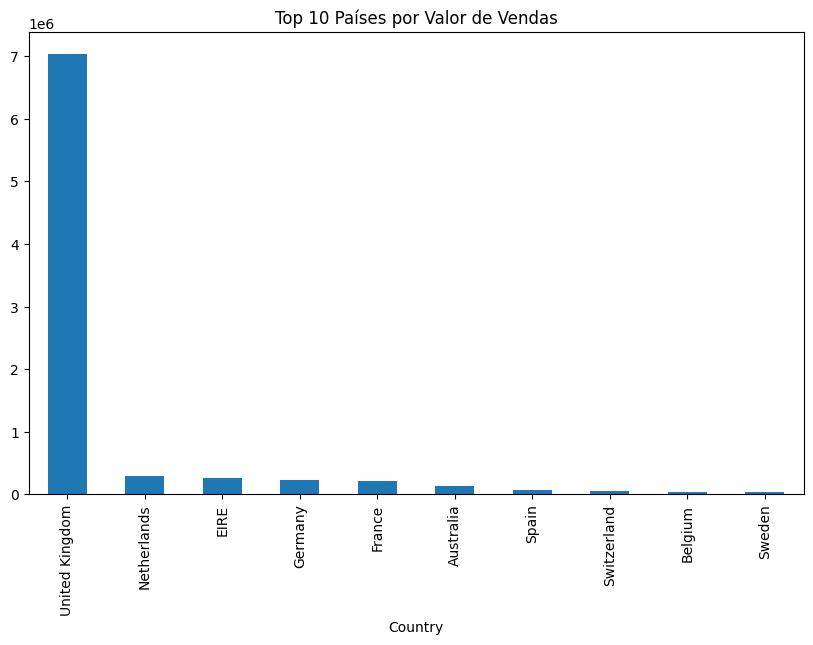

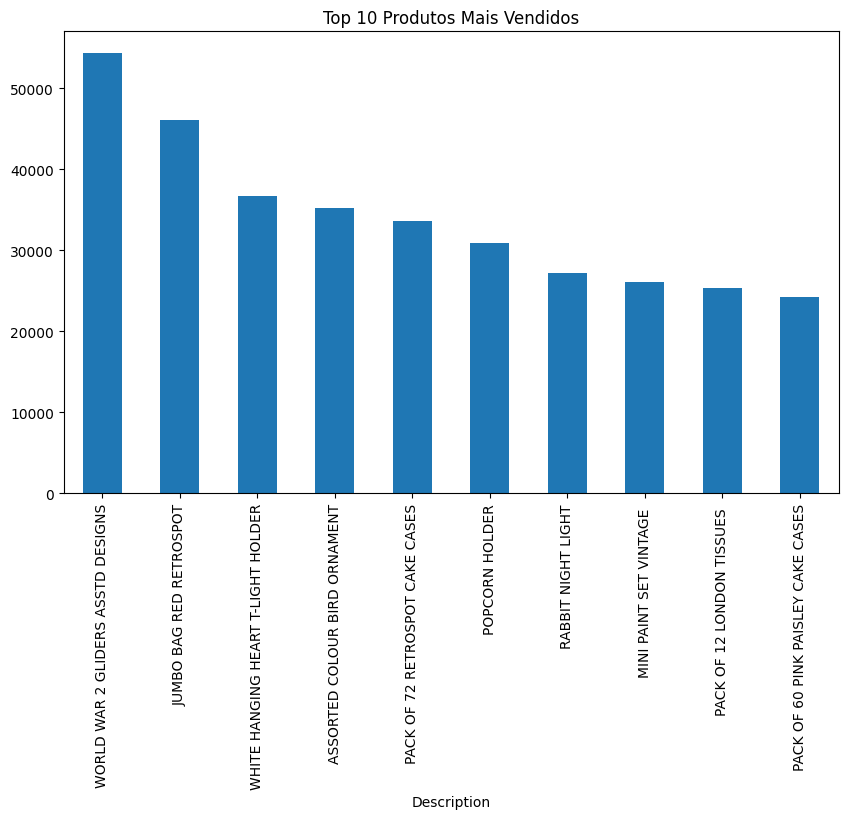

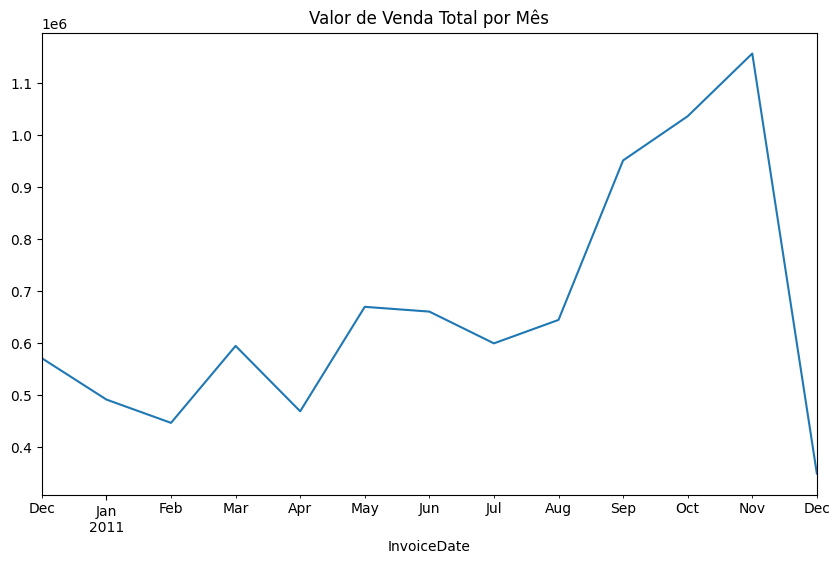

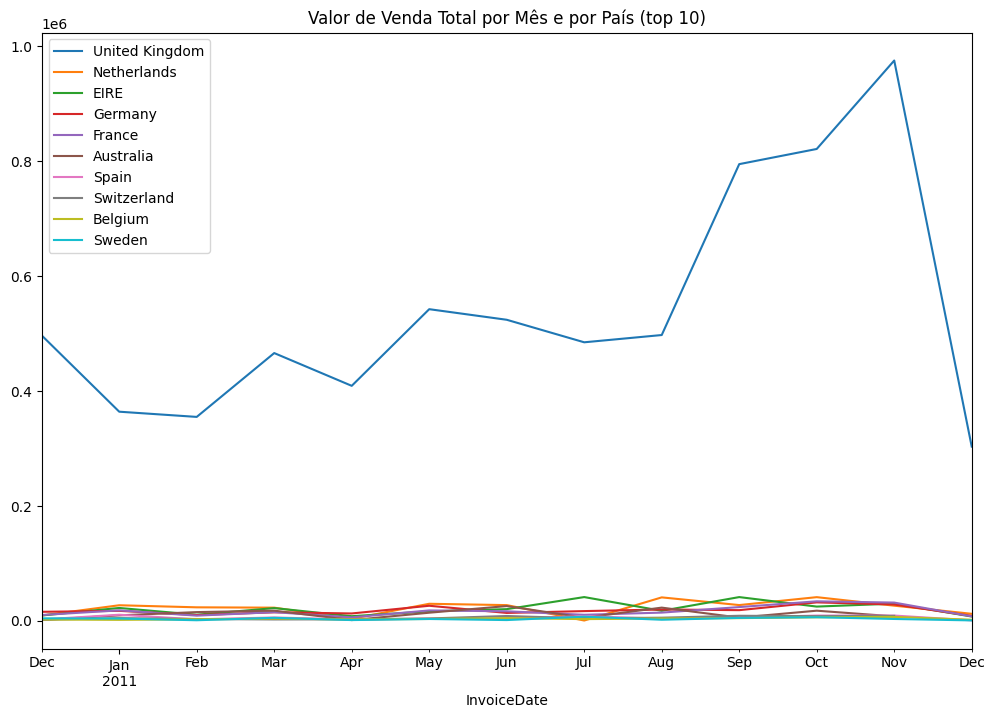

In [18]:
# Top 10 países por valor de vendas
plt.figure(figsize=(10, 6))
df.groupby('Country')['TotalPrice'].sum().nlargest(10).plot(kind='bar')
plt.title('Top 10 Países por Valor de Vendas')
plt.show()

# Top 10 produtos mais vendidos
plt.figure(figsize=(10, 6))
df.groupby('Description')['Quantity'].sum().nlargest(10).plot(kind='bar')
plt.title('Top 10 Produtos Mais Vendidos')
plt.show()

# Valor de venda total por mês
plt.figure(figsize=(10, 6))
df.set_index('InvoiceDate')['TotalPrice'].resample('ME').sum().plot()
plt.title('Valor de Venda Total por Mês')
plt.show()

# Valor de venda total por mês e por país (top 10)
top_10_conuntries = df.groupby('Country')['TotalPrice'].sum().nlargest(10).index
plt.figure(figsize=(12, 8))
for country in top_10_conuntries:
  df_country = df[df['Country'] == country]
  df_country.set_index('InvoiceDate')['TotalPrice'].resample('ME').sum().plot(label=country)
plt.title('Valor de Venda Total por Mês e por País (top 10)')
plt.legend()
plt.show()

# Etapa 10: Cálculo do RFM

In [20]:
customer_invoice_data = df.groupby(['CustomerID', 'InvoiceNo']).agg({'InvoiceDate': 'max', 'TotalPrice': 'sum'})
customer_invoice_data.columns = ['InvoiceDate', 'TotalOrderValue']
customer_invoice_data.reset_index(inplace=True)

# Calculando RFM
rfm = customer_invoice_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalOrderValue': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Exporta o resultado para um arquivo CSV
rfm.to_csv('rfm_output.csv')